### Objetivos:

* **Aplicar os algoritmos de aprendizado supervisionado para classificação (algoritmos SVC e KNN) ao conjunto de dados rotulados Titanic (disponível na plataforma Kaggle);**
<br><br>
* **Encontrar os melhores hiperparâmetros para cada um dos algoritmos de aprendizado supervisionado, utilizando o algoritmo Grid Search;**
<br><br>
* **Comparar os resultados obtidos por meio da validação cruzada, usando a classe KFold e a métrica de avaliação curva ROC-AUC;**
<br><br>
* **Justificar a escolha das melhores técnicas para o aprendizado supervisionado e os resultados obtidos nesse trabalho.**

## 1 - Seleção e pré-processamento dos dados

In [1]:
# Importa algumas bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Importa as classes para plotar a curva ROC, separar os dados em treino e teste e fazer validação cruzada usando K-Fold
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

# Ignora alguns avisos
import warnings
warnings.filterwarnings("ignore")

### Classe para indexação --> Substitui valores contínuos contidos em intervalos pré-definidos por índices (valores discretos)

In [2]:
# Classe para indexação de conjuntos de valores contínuos
class Indexacao_Coluna(): 

    # A seguinte função pode ser usada para substituir valores contínuos de uma coluna, divididos em intervalos, por índices. 
    # Quanto maior os valores extremos do intervalo, maior o valor do índice
    def index_intervals_1(self, dataframe, column, interval_1, interval_2, include_upper = False):
    
        # A indexação inicia-se pelo valor 1
        index = 1
    
        # Cria intervalos de valores e substitui, por um índice numérico, os intervalos de valores da coluna
        for i, j in zip(np.arange(interval_1[0], interval_1[1], interval_1[2]), 
                        np.arange(interval_2[0], interval_2[1], interval_2[2])):
            
            # Se o programador quiser um intervalo (valor1, valor2]...
            if include_upper == True:
        
            # Se o intervalo criado não apresentar valores continuos (apresentar valor NaN), não executará qualquer indexação
                if dataframe.loc[dataframe[column].gt(i) & dataframe[column].le(j), column].empty:
            
                    pass
        
                # Caso contrário...
                else:
            
                    # Faz a indexação, substituindo os valores da coluna pertencentes ao intervalo 
                    dataframe.loc[dataframe[column].gt(i) & dataframe[column].le(j), column] = index
            
                    # Soma 1 ao índice, preparando-o para a próxima indexação
                    index += 1
            
            # Se o programador quiser um intervalo [valor1, valor2)...
            else:
                
            # Se o intervalo criado não apresentar valores continuos (apresentar valor NaN), não executará qualquer indexação
                if dataframe.loc[dataframe[column].ge(i) & dataframe[column].lt(j), column].empty:
            
                    pass
        
                # Caso contrário...
                else:
            
                    # Faz a indexação, substituindo os valores da coluna pertencentes ao intervalo 
                    dataframe.loc[dataframe[column].ge(i) & dataframe[column].lt(j), column] = index
            
                    # Soma 1 ao índice, preparando-o para a próxima indexação
                    index += 1
                
                

            
    # A seguinte função pode ser usada para substitui valores contínuos de uma coluna, divididos em intervalos, por índices. 
    # ascending = True --> Quanto maior a quantidade de valores dentro do intervalo, maior o valor do índice.
    def index_intervals_2(self, dataframe, column, interval_1, interval_2, ascending = True):
    
    ############## Cria uma lista de dicionários com os itens qntd de valores no intervalo: intervalo de valores ##############
    
    
        # Lista vazia para armazenar dicionários -> qntd de valores no intervalo (key): intervalo (value)
        qntd_inter = []

        # Cria intervalos de valores e substitui, por um índice numérico, os intervalos de valores da coluna
        for i, j in zip(np.arange(interval_1[0], interval_1[1], interval_1[2]), 
                        np.arange(interval_2[0], interval_2[1], interval_2[2])):
    
            # Armazena a qntd de valores no intervalo
            qntd_itens = len(dataframe.loc[dataframe[column].ge(i) & dataframe[column].lt(j), column])
        
            # Adiciona o dicionário na lista qntd_item
            qntd_inter.append({qntd_itens: [i, j]})
    
        # Se o parâmetro ascending = True...
        if ascending == True:
        
            # Organiza os dicionários pela quantidade de itens nos intervalos de valores
            qntd_inter = sorted(qntd_inter, key=lambda d: list(d.keys()), reverse = False)

    ########### Modificação dos dicionários - index (key): (qntd de itens, intervalo dos valores da coluna) (value) ###########

        # A indexação inicia-se pelo valor 1
        index = 1

        # Captura cada valor de posição (index) dos dicionários e os próprios dicionários da lista qntd_inter, respec. 
        for i_lista, dictionary in enumerate(qntd_inter):
    
            # Armazena a key (qntd de valores no intervalo) e o value (intervalo) do dicionário selecionado pelo looping
            key, value = list(dictionary.keys())[0], list(dictionary.values())[0]
        
            # Se a key for diferente de zero...
            if key != 0:
        
                # Cria um novo dicionário, tranformando o valor da variável index em key e o novo value é a key e o value antigos
                dictionary[index] = (key, dictionary.pop(key))     
            
                # Soma 1 ao índice, preparando-o para a próxima indexação
                index += 1
        
                # Substitui o antigo dicionário selecionado da lista pelo looping pelo novo dicionário criado
                qntd_inter[i_lista] = dictionary 

    ######## Cria uma lista com os índices atribuído aos valores, repetindo-os pela qntd de valores presentes no intervalo ####

        print('index: (qntd de valores contínuos dentro do intervalo avaliado, intervalo avaliado):\n')
        print(qntd_inter)
    
        # Cria uma lista vazia para armazenar os índices repetidos, atribuídos aos valores dos intervalos
        valores = []

        # Captura cada dicionário na lista qntd_inter
        for dictionary in qntd_inter:
    
            # Armazena a key e os values qntd de valores no intervalo e intervalo
            key, qntd, value = list(dictionary.keys())[0], list(dictionary.values())[0][0], list(dictionary.values())[0][1]
    
            # Se a key for diferente de zero...
            if key != 0:
            
                # Repete o índice do intervalo pelo cálculo: (índice) * (qntd de valores no intervalo) e adiciona à lista valores
                valores += [key] * qntd
 

        # Ordena os valores da coluna no dataframe, captura seus índices no dataframe e os armazena em uma lista
        i_serie = dataframe[column].sort_values().index.tolist()

        # Substitui todos os valores numéricos contínuos na coluna pelos seus respectivos índices gerados por essa função
        dataframe.loc[i_serie, column] = valores

In [3]:
# Nomes que serão dados às colunas na mesma ordem em que aparecem
titanic_cols = [ 'ID', 'Sobrevivente', 'Classe', 'Nome', 'Sexo', 'Idade', 'EsposasEIrmas', 
                'Parentes', 'Passagem', 'Tarifa', 'Cabine', 'Embarque']

In [4]:
# Carrega o arquivo que contém o conjunto de dados Titanic
titanic_df_orig = pd.read_csv('Kaggle_Titanic\\train.csv', names = titanic_cols, header = 0)

In [5]:
# Exibe as 5 primeiras linhas do dataframe titanic_df_orig
titanic_df_orig.head()

,ID,Sobrevivente,Classe,Nome,Sexo,Idade,EsposasEIrmas,Parentes,Passagem,Tarifa,Cabine,Embarque
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Exibe a qntd de linhas e colunas do dataframe
titanic_df_orig.shape

(891, 12)

In [7]:
# Faz uma cópia do dataframe titanic_df_orig
titanic_df = titanic_df_orig.copy()

**As colunas <font color='red'>Nome</font> e <font color='red'>ID</font> serão eliminadas mais a frente, pois essas colunas não possuem relevância para os trabalhos envolvendo *Machine Learning*.**

### 1.1 - Atributo Sexo

In [8]:
# Exibe os valores distintos na coluna Sexo e mostra a frequência de cada valor
titanic_df['Sexo'].value_counts()

male      577
female    314
Name: Sexo, dtype: int64

In [9]:
# Exibe a quantidade de valores na coluna Sexo, o número de elementos distintos na coluna e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Sexo'])}")
print(f"Valores distintos: {titanic_df['Sexo'].nunique()}")
print(f"Valores NaN: {titanic_df['Sexo'].isnull().sum()}")

Qntd de valores na coluna: 891
Valores distintos: 2
Valores NaN: 0


In [10]:
# Transformação de valores não numéricos para numéricos do atributo previsor Sexo
labelecoder = LabelEncoder()
titanic_df['Sexo'] = labelecoder.fit_transform(titanic_df['Sexo'])

In [11]:
# Exibe a relação entre o sexo das pessoas e sobreviventes
titanic_df[['Sexo', 'Sobrevivente']].groupby(['Sexo'], 
                                as_index=False).mean().sort_values(by='Sobrevivente', ascending=False)

,Sexo,Sobrevivente
0,0,0.742038
1,1,0.188908


In [12]:
# Exibe o que significa cada valor gerado pelo LabelEncoder: 0 = female, 1 = male
labelecoder.inverse_transform([0, 1])

array(['female', 'male'], dtype=object)

**Dentre todas as mulheres (valor 0) a bordo do navio, 74.20% sobreviveram ao naufrágio, enquanto que dentre todos os homens a bordo, apenas 18.89% sobreviveram.**

### 1.2 - Atributo Embarque

In [13]:
# Exibe os valores distintos na coluna Embarque e mostra a frequência de cada valor
titanic_df['Embarque'].value_counts()

S    644
C    168
Q     77
Name: Embarque, dtype: int64

In [14]:
# Exibe a quantidade de valores na coluna Embarque, o número de elementos distintos na coluna e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Embarque'])}")
print(f"Valores distintos: {titanic_df['Embarque'].nunique()}")
print(f"Valores NaN: {titanic_df['Embarque'].isnull().sum()}")

Qntd de valores na coluna: 891
Valores distintos: 3
Valores NaN: 2


**Verifica-se a necessidade de preenchimento de 2 valores NaN presentes na coluna Embarque. A decisão tomada para essa tarefa é de preencher esses valores com os valores/siglas que mais aparecem na coluna: sigla S**

In [15]:
# Substitui valores NaN, na coluna Embarque, pela sigla que mais aparece (S)
titanic_df['Embarque'].fillna('S', inplace = True)

**Devido a presença de valores categóricos na coluna Embarque, utilizou-se a classe LabelEncoder para transformação desses valores categóricos em numéricos discretos.**

In [16]:
# Transformação de valores não numéricos para numéricos do atributo previsor Embarque
titanic_df['Embarque'] = labelecoder.fit_transform(titanic_df['Embarque'])

In [17]:
# Exibe o que significa cada valor gerado pelo LabelEncoder: 0 = C, 1 = Q, 2 = S
labelecoder.inverse_transform([0, 1, 2])

array(['C', 'Q', 'S'], dtype=object)

In [18]:
# Exibe a relação entre o embarque e sobreviventes
titanic_df[['Embarque', 'Sobrevivente']].groupby(['Embarque'], 
                                as_index=False).mean().sort_values(by='Sobrevivente', ascending=False)

,Embarque,Sobrevivente
0,0,0.553571
1,1,0.389610
2,2,0.339009


**A maior taxa de sobrevivência, quando avaliados os portos de embarque, é das pessoas que embarcaram pelo porto 0 (porto C) com taxa de 55.36%, seguido do porto 1 (porto Q) com taxa de 38.96% e, por último, porto 2 (porto S) com 33.90%**

### 1.3 - Atributo Passagem

In [19]:
# Armazena todos os valores únicos presentes na coluna Passagem para uso na Classe OneHotEncoder
# Essa variável armazena os nomes das colunas que a classe OneHotEncoder vai gerar com os valores discretos na coluna Passagem
colunas_passagem = list(set(titanic_df['Passagem']))

# Exibe os dados da coluna Passagem
titanic_df['Passagem']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Passagem, Length: 891, dtype: object

**Pode-se verificar a necessidade de transformar os valores categóricos da coluna Passagem em numéricos discretos, uma vez que os algoritmos de *Machine Learning* não trabalham com dados desse tipo.**

In [20]:
# Transformação de valores não numéricos para numéricos do atributo previsor Passagem
titanic_df['Passagem'] = labelecoder.fit_transform(titanic_df['Passagem'])

In [21]:
# Exibe a quantidade de valores na coluna Passagem, valores máximo e mínimo, n° de elementos distintos e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Passagem'])}")
print(f"Valor min-max: {titanic_df['Passagem'].min(), titanic_df['Passagem'].max()}")
print(f"Valores distintos: {titanic_df['Passagem'].nunique()}")
print(f"Valores NaN: {titanic_df['Passagem'].isnull().sum()}")

Qntd de valores na coluna: 891
Valor min-max: (0, 680)
Valores distintos: 681
Valores NaN: 0


**É nítida a necessidade de normalizar os dados ou de transformar os valores discretos em colunas, evitando que alguns atributos sejam tratados com maior relevância que outros pelos algoritmos de *Machine Learning*.**

In [22]:
# Qntd de valores repetidos/duplicados na coluna Passagem
print(titanic_df['Passagem'].duplicated().sum())

210


In [23]:
# Exibe o percentual dos valores duplicados na coluna Passagem
percentual_duplicadas = str(round((titanic_df['Passagem'].duplicated().sum() / len(titanic_df['Passagem']))*100, 1)) + '%'
percentual_duplicadas

'23.6%'

**Foi decidido então, para a coluna <font color='red'>Passagem</font>, que a transformação de valores discretos em colunas é a melhor solução, uma vez que o intervalo de valores discretos distintos é relativamente grande. Apesar do aumento da dimensionalidade do conjunto de dados aumentar o custo computacional (maior tempo de processamento e aumento do consumo de memória para armazenamento dos dados), transformar os valores discretos em colunas facilitará o aprendizado dos modelos, gerando melhores resultados de acurácia, por exemplo.**

In [24]:
# Transforma os valores discretos distintos em colunas
onehotencoder = OneHotEncoder(sparse=False)
titanic_df[colunas_passagem] = onehotencoder.fit_transform(titanic_df['Passagem'].values.reshape(-1, 1))
titanic_df.drop(columns = 'Passagem', inplace = True)

### 1.4 - Atributo Tarifa

In [25]:
# Exibe a quantidade de valores na coluna Tarifa, valores máximo e mínimo, n° de elementos distintos e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Tarifa'])}")
print(f"Valor min-max: {titanic_df['Tarifa'].min(), titanic_df['Tarifa'].max()}")
print(f"Valores distintos: {titanic_df['Tarifa'].nunique()}")
print(f"Valores NaN: {titanic_df['Tarifa'].isnull().sum()}")

Qntd de valores na coluna: 891
Valor min-max: (0.0, 512.3292)
Valores distintos: 248
Valores NaN: 0


In [26]:
# Exibe a relação entre a tarifa das passagens e sobreviventes
titanic_df[['Tarifa', 'Sobrevivente']].groupby(pd.cut(titanic_df['Tarifa'], 
                                            np.arange(0, 520, 30))).mean().sort_values(by='Sobrevivente', ascending=False)


,Tarifa,Sobrevivente
Tarifa,,
"(120, 150]",137.360167,0.888889
"(90, 120]",108.587716,0.789474
"(150, 180]",155.146767,0.666667
"(210, 240]",219.710189,0.666667
"(240, 270]",258.973950,0.625000
"(60, 90]",76.581858,0.600000
"(30, 60]",42.801787,0.482143
"(0, 30]",13.458611,0.319315
"(180, 210]",NaN,NaN


**De um modo geral, as pessoas que pagaram maiores tarifas para embarcar no navio apresentam maiores taxas de sobrevivência do que as pessoas que pagaram tarifas mais baratas.**
<br><br>
**A coluna <font color='red'>Tarifa</font> foi submetida à indexação dos seus valores contínuos. Cada intervalo de valores contínuos representava um valor discreto de índice, acarretando na transformação dos valores contínuos em discretos. Os índices gerados, acompanhados dos seus intervalos de valores foram 1 = [0, 20); 2 = [20, 40); ... 14 = [500, 520). Portanto, todos os valores contínuos na coluna foram substituídos por índices, respeitando os intervalos que cada valor contínuo pertence. Essa transformação levou a um melhor aprendizado do modelos de classificação usados nesse trabalho, gerando melhores valores de acurácia.**

In [27]:
# Transforma os valores contínuos em discretos por meio da indexação dos valores na coluna Tarifa
I = Indexacao_Coluna()
I.index_intervals_1(dataframe = titanic_df, column = 'Tarifa', interval_1 = [0, 520, 20], interval_2 = [20, 530, 20])

### 1.5 - Atributo Cabine

In [28]:
# Exibe a quantidade de valores na coluna Cabine, o número de elementos distintos na coluna e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Cabine'])}")
print(f"Valores distintos: {titanic_df['Cabine'].nunique()}")
print(f"Valores NaN: {titanic_df['Cabine'].isnull().sum()}")

Qntd de valores na coluna: 891
Valores distintos: 147
Valores NaN: 687


In [29]:
print(f"Percentual de valores NaN: {round((titanic_df['Cabine'].isnull().sum() / len(titanic_df['Cabine']))*100, 2)} %")

Percentual de valores NaN: 77.1 %


In [30]:
# Exibe os dados da coluna 'Cabine'
titanic_df['Cabine']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabine, Length: 891, dtype: object

**Devido à alta quantidade de valores NaN na coluna <font color='red'>Cabine</font>, a decisão tomada para essa coluna é de eliminá-la, ou seja, não utilizá-la no trabalho de *Machine Learning*. Utilizar qualquer tarefa de preenchimento de dados com a coluna na situação em que boa parte dos dados (77,1%) é composta por valores NaN acarretaria em inserir dados ruidosos nos modelos de *Machine Learning*, atrapalhando seus aprendizados. A eliminação da coluna acontecerá futuramente.**

### 1.6 - Atributo Classe

In [31]:
# Exibe os valores distintos na coluna Classe e mostra a frequência de cada valor
titanic_df['Classe'].value_counts()

3    491
1    216
2    184
Name: Classe, dtype: int64

In [32]:
# Exibe a quantidade de valores na coluna Classe, o número de elementos distintos na coluna e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Classe'])}")
print(f"Valores distintos: {titanic_df['Classe'].nunique()}")
print(f"Valores NaN: {titanic_df['Classe'].isnull().sum()}")

Qntd de valores na coluna: 891
Valores distintos: 3
Valores NaN: 0


In [33]:
# Exibe a relação entre a classe das passagens e sobreviventes
titanic_df[['Classe', 'Sobrevivente']].groupby(['Classe'], 
                                as_index=False).mean().sort_values(by='Sobrevivente', ascending=False)

,Classe,Sobrevivente
0,1,0.629630
1,2,0.472826
2,3,0.242363


**Há mais pessoas na classe 3 (491 pessoas), seguido da classe 1 (216) e 2 (184).** 
<br><br>
**Quando avaliadas as pessoas dentro das mesmas classes, as pessoas da Classe 1 tem maior taxa de sobrevivência (62.96%), seguida da classe 2 (47.28%) e 3 (24.24%).**

### 1.7 - Atributo Idade

In [34]:
# Exibe a quantidade de valores na coluna Idade, valores máximo e mínimo, n° de elementos distintos e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Idade'])}")
print(f"Valor min-max: {titanic_df['Idade'].min(), titanic_df['Idade'].max()}")
print(f"Valores distintos: {titanic_df['Idade'].nunique()}")
print(f"Valores NaN: {titanic_df['Idade'].isnull().sum()}")

Qntd de valores na coluna: 891
Valor min-max: (0.42, 80.0)
Valores distintos: 88
Valores NaN: 177


**O atributo <font color='red'>Idade</font> tem seus valores variando de 0,42 (fracionário para bebês menores de 1 ano de idade) a 80 anos. Os valores NaN de idade serão preenchidos com o auxílio do algoritmo de *Machine Learning* KNN, executado em uma seção mais a frente;**

In [35]:
# Exibe a contagem de valores para a relação entre a idade das pessoas e sobreviventes
idade_sobrev = titanic_df[['Idade', 'Sobrevivente']].groupby(pd.cut(titanic_df['Idade'], 
                                                np.arange(0, 81, 5))).count().sort_values(by='Sobrevivente', ascending=False)

idade_sobrev # Exibe todas as linhas do dataframe

,Idade,Sobrevivente
Idade,,
"(20, 25]",122,122
"(25, 30]",108,108
"(15, 20]",96,96
"(30, 35]",88,88
"(35, 40]",67,67
"(40, 45]",47,47
"(0, 5]",44,44
"(45, 50]",39,39
"(50, 55]",24,24


In [36]:
# Exibe a relação entre a idade das pessoas e sobreviventes
idade_sobrev = titanic_df[['Idade', 'Sobrevivente']].groupby(pd.cut(titanic_df['Idade'], 
                                                np.arange(0, 81, 5))).mean().sort_values(by='Sobrevivente', ascending=False)

idade_sobrev.head(5) # Exibe as 5 primeiras linhas do dataframe

,Idade,Sobrevivente
Idade,,
"(75, 80]",80.000000,1.000000
"(0, 5]",2.503864,0.704545
"(10, 15]",13.447368,0.578947
"(30, 35]",32.937500,0.465909
"(35, 40]",37.828358,0.417910


In [37]:
# Exibe a relação entre a idade das pessoas e sobreviventes
idade_sobrev = titanic_df[['Idade', 'Sobrevivente']].groupby(pd.cut(titanic_df['Idade'], 
                                                np.arange(0, 81, 5))).mean().sort_values(by='Sobrevivente', ascending=False)

idade_sobrev.tail(5) # Exibe as 5 últimas linhas do dataframe

,Idade,Sobrevivente
Idade,,
"(20, 25]",23.004098,0.344262
"(15, 20]",18.083333,0.343750
"(60, 65]",62.857143,0.285714
"(65, 70]",68.666667,0.000000
"(70, 75]",71.625000,0.000000


**O grupo de pessoas com maior taxa de sobrevivência corresponde as idades entre 0 e 5 anos, com 70.45%. A faixa de 75 a 80 anos não foi levada em conideração porque essa faixa apresenta apenas 1 pessoa a qual sobreviveu ao naufrágio.** 
<br><br>
**Por sua vez, o grupo com menor taxa de sobrevivência apresenta idades entre 65 e 75 anos, com taxa de 0% de sobrevivência. De um modo geral, pessoais mais velhas, principalmente a partir de 60 anos de idade, tendem a apresentar uma menor taxa de sobrevivência.**

### 1.8 - Atributo Esposas e Irmãs

In [38]:
# Exibe a qntd de valores na coluna Esposas e Irmãs, valores máximo e mínimo, n° de elementos distintos e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['EsposasEIrmas'])}")
print(f"Valor min-max: {titanic_df['EsposasEIrmas'].min(), titanic_df['EsposasEIrmas'].max()}")
print(f"Valores distintos: {titanic_df['EsposasEIrmas'].nunique()}")
print(f"Valores NaN: {titanic_df['EsposasEIrmas'].isnull().sum()}")

Qntd de valores na coluna: 891
Valor min-max: (0, 8)
Valores distintos: 7
Valores NaN: 0


**A quantidade de <font color='red'>Esposas e Irmãs</font> possui uma amplitude relativamente pequena, com um valor máximo menor que 10.**

In [39]:
# Exibe a relação entre a qntd de esposa + irmãs e sobreviventes
titanic_df[['EsposasEIrmas', 'Sobrevivente']].groupby(['EsposasEIrmas'], 
                                                 as_index=False).mean().sort_values(by='Sobrevivente', ascending=False)

,EsposasEIrmas,Sobrevivente
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


**Existe uma tendência de quanto maior o número de esposasEIrmãs, menor a taxa de sobrevivência. Enquanto a taxa para 1 Esposa ou Irmã é de 53.59%, a taxa para 8 Esposa + irmãs é de 0%**

### 1.9 - Atributo Parentes

In [40]:
# Exibe a qntd de valores na coluna Parentes, valores máximo e mínimo, n° de elementos distintos e qntd de valores NaN
print(f"Qntd de valores na coluna: {len(titanic_df['Parentes'])}")
print(f"Valor min-max: {titanic_df['Parentes'].min(), titanic_df['Parentes'].max()}")
print(f"Valores distintos: {titanic_df['Parentes'].nunique()}")
print(f"Valores NaN: {titanic_df['Parentes'].isnull().sum()}")

Qntd de valores na coluna: 891
Valor min-max: (0, 6)
Valores distintos: 7
Valores NaN: 0


**A quantidade de <font color='red'>Parentes</font> possui uma amplitude relativamente pequena, com um valor máximo igual a 6.**

In [41]:
# Exibe a relação entre a qntd de parentes das pessoas e sobreviventes
titanic_df[['Parentes', 'Sobrevivente']].groupby(['Parentes'], 
                                                 as_index=False).mean().sort_values(by='Sobrevivente', ascending=False)

,Parentes,Sobrevivente
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


**A relação entre n° de parentes e sobreviventes não é tão clara, onde 3 parentes implica em uma taxa de sobrevivência de 60%, 1 parente implica em uma taxa de 55.08%, 2 parentes em taxa de 50%, 0 parente em taxa de 34.36%, etc.**

In [42]:
# Dados originais -- Contabiliza a qntd de instâncias não-nulas (count), a média dos valores (mean), o desvio padrão (std), 
# o valor mínimo (min), o valor máximo (max) e as distribuições (quartis) de 25%, 50% e 75%
titanic_df_orig.describe()

,ID,Sobrevivente,Classe,Idade,EsposasEIrmas,Parentes,Tarifa
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [43]:
# Dados tratados -- Contabiliza a qntd de instâncias não-nulas (count), a média dos valores (mean), o desvio padrão (std), 
# o valor mínimo (min), o valor máximo (max) e as distribuições (quartis) de 25%, 50% e 75%
titanic_df.describe()

,ID,Sobrevivente,Classe,Sexo,Idade,EsposasEIrmas,Parentes,Tarifa,Embarque,113514,...,36973,19972,349216,C 7076,113059,SC/Paris 2123,2693,PC 17760,13507,11771
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,2.074074,1.536476,0.003367,...,0.001122,0.001122,0.001122,0.001122,0.002245,0.004489,0.001122,0.001122,0.001122,0.002245
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,2.079086,0.791503,0.057961,...,0.033501,0.033501,0.033501,0.033501,0.047351,0.066890,0.033501,0.033501,0.033501,0.047351
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,2.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,14.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**As colunas Sexo e Embarque não são mostradas acima por <font color='red'>titanic_df_orig</font>, mas são mostradas por <font color='red'>titanic_df</font>. Isso aconteceu porque o método <font color='green'>describe</font> só é capaz de listar métricas a respeito de dados numéricos.** 
<br><br>
**Fica nítido a existência de muitos valores do tipo NaN na coluna <font color='red'>Idade</font> (count: 714 != 891 das outras colunas). Portanto, torna-se evidente a necessidade de uma preparação dos dados para tratar o atributo <font color='red'>Idade</font> que possui muitas instâncias nulas.**
<br><br>
**A seguir, são deletadas as colunas ID, Nome e Cabine que não serão usadas no treinamento dos modelos.**

In [44]:
# Deleta as colunas ID e Nome
conj_modelo = titanic_df.drop(labels=['ID', 'Nome', 'Cabine'], axis = 1)

### 1.10 - Preenchimento dos valores NaN no atributo Idade com o algoritmo KNN

**A partir de agora, os dados serão preparados para a previsão dos valores faltantes de idade (177 valores NaN). Essa previsão será executada a partir do treinamento do modelo KNN.**

### -> <font color ='red'>Padronização</font> e <font color ='red'>separação</font> dos dados de todos os atributos do dataframe conj_modelo

In [45]:
# Instancia a classe StandardScaler para padronização dos dados
scaler = StandardScaler()

# Faz o treinamento e a padronização dos dados em conj_modelo
X_regressao_st = pd.DataFrame(data = scaler.fit_transform(conj_modelo), columns = conj_modelo.columns)

idade_mean_st = scaler.mean_[3] # Armazena a média da coluna idade

idade_std_st = scaler.scale_[3] # Armazena o desvio padrão da coluna idade

In [46]:
# Calcula o coef de correlação de Pearson e salva os 20 atributos de maior coef de correlação com o atributo Idade
colunas_X_regressao = (np.abs(X_regressao_st.corr(method='pearson')['Idade'])).nlargest(n=21, keep='first').index[1:21].tolist()

# Exibe os 15 primeiros atributos da lista dos atributos (colunas_X_regressao) com os maiores coefs de correlação
(np.abs(X_regressao_st.corr(method='pearson')['Idade'])).nlargest(n=15, keep='first')

Idade            1.000000
Classe           0.369226
EsposasEIrmas    0.308247
Parentes         0.189119
382652           0.129770
CA. 2343         0.114291
31418            0.114137
Tarifa           0.107736
17463            0.106551
218629           0.106551
370129           0.105261
220845           0.103971
2648             0.102729
349227           0.102390
8471             0.099305
Name: Idade, dtype: float64

In [47]:
# Armazena os atributos previsores com maiores índices de correlação, mas apenas as instâncias com NaN no atributo Idade
nulos = X_regressao_st[X_regressao_st['Idade'].isnull()][colunas_X_regressao]

In [48]:
# Apaga todas as instâncias que apresente, pelo menos, 1 valor NaN em alguma coluna (apenas a coluna Idade apresenta NaN's)
X_regressao_dropna = X_regressao_st.dropna(axis = 0)

In [49]:
# Salva o atributo-alvo Idade em uma variável e os atributos previsores em outra variável
y_regressao_dropna = X_regressao_dropna['Idade']
X_regressao_dropna = X_regressao_dropna[colunas_X_regressao]

### -> <font color ='red'>Treinamento</font> do algoritmo <font color='orange'>KNN</font> e <font color ='red'> as previsões</font> das idades faltantes

In [50]:
# Importa a classe do modelo Knn
from sklearn.neighbors import KNeighborsRegressor as Knn

In [51]:
# Configura e instancia o modelo
k = Knn(n_neighbors=5)

In [52]:
# Treina o modelo
k.fit(X_regressao_dropna, y_regressao_dropna);

In [53]:
# Prevê os valores de Idade com os 4 atributos previsores salvos na variável 'nulos'
prevs = k.predict(nulos)

In [54]:
# Substitui os valores NaN no atributo Idade pelos previstos. Cálculo de despadronização dos valores previstos:
# Z = (X - mean) / std --> X = Z * (std) + mean
conj_modelo.loc[conj_modelo['Idade'].isnull(), 'Idade'] = (prevs * idade_std_st) + idade_mean_st

In [55]:
# Avalia o conjunto de dados com uma análise estatística descritiva
conj_modelo.describe()

,Sobrevivente,Classe,Sexo,Idade,EsposasEIrmas,Parentes,Tarifa,Embarque,113514,29106,...,36973,19972,349216,C 7076,113059,SC/Paris 2123,2693,PC 17760,13507,11771
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.622525,0.523008,0.381594,2.074074,1.536476,0.003367,0.003367,...,0.001122,0.001122,0.001122,0.001122,0.002245,0.004489,0.001122,0.001122,0.001122,0.002245
std,0.486592,0.836071,0.477990,13.427234,1.102743,0.806057,2.079086,0.791503,0.057961,0.057961,...,0.033501,0.033501,0.033501,0.033501,0.047351,0.066890,0.033501,0.033501,0.033501,0.047351
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,29.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,14.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
# Transforma os valores contínuos em discretos por meio da indexação dos valores na coluna Idade
I = Indexacao_Coluna()
I.index_intervals_1(dataframe = conj_modelo, column = 'Idade', interval_1 = [0, 76, 5], 
                    interval_2 = [5, 81, 5], include_upper = True)

In [57]:
# Avalia o conjunto de dados com uma análise estatística descritiva
conj_modelo.describe()

,Sobrevivente,Classe,Sexo,Idade,EsposasEIrmas,Parentes,Tarifa,Embarque,113514,29106,...,36973,19972,349216,C 7076,113059,SC/Paris 2123,2693,PC 17760,13507,11771
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,6.377104,0.523008,0.381594,2.074074,1.536476,0.003367,0.003367,...,0.001122,0.001122,0.001122,0.001122,0.002245,0.004489,0.001122,0.001122,0.001122,0.002245
std,0.486592,0.836071,0.477990,2.684808,1.102743,0.806057,2.079086,0.791503,0.057961,0.057961,...,0.033501,0.033501,0.033501,0.033501,0.047351,0.066890,0.033501,0.033501,0.033501,0.047351
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,6.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,8.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,3.000000,1.000000,16.000000,8.000000,6.000000,14.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Pode-se observar agora que todas as colunas, incluindo a coluna Idade, tem a mesma quantidade de instâncias não nulas (count = 891)**

### 1.11 - <font color='red'>*Oversampling*</font> dos dados

In [58]:
# Separação do conjunto de dados originais tratados: X = atributos previsores; y = atributo-alvo
X = conj_modelo.drop(columns=['Sobrevivente']).copy()
y = conj_modelo['Sobrevivente'].copy()

In [59]:
# Gera novas instâncias para a classe minoritária 
from imblearn.over_sampling import SMOTEN
sampler = SMOTEN(k_neighbors=5, sampling_strategy = 'minority', random_state=0)
X, y = sampler.fit_resample(X, y)

## 2 - Seleção dos atributos

**Para este trabalho, são usados 2 algoritmos de aprendizado supervisionado: SVM para classificação (<font color='green'>SVC</font>) e <font color='green'>KNN</font> para classificação**
<br><br>
**<font color='green'>SVC</font> --> Busca <font color='red'>maximizar a margem do hiperplano</font> que separa as instâncias, adotando o conceito de margem suave em que a quantidade de erros de classificação tolerada é especificada pelo programador por meio do <font color='red'>parâmetro C</font>. Esse algoritmo resolve os problemas de não linearidade das instâncias com o auxílio de funções <font color='red'>kernel</font> que ampliam a dimensionalidade dos dados, possibilitando encontrar uma distribuição linearmente separável em dimensões maiores. O SVC adequa-se bem aos conjuntos de dados de alta dimensão e poucas instâncias.**
<br><br>
**<font color='green'>KNN</font> --> Classifica uma instância de teste com os <font color='red'>rótulos mais frequentes</font> nos K vizinhos mais próximos dela. Esse algoritmo, assim como o SVC, consegue lidar com problemas não linearmente separáveis. É esperado que o KNN seja mais eficiente quanto menor for a dimensão (quantidade de atributos);**

**A medida que <font color='red'>a quantidade de instâncias cresce</font>, o algoritmo <font color='green'>SVC</font> fica mais suscetível a apresentar <font color='red'>*overfitting*</font> e <font color='red'>mais lento para convergir</font> para uma solução quando comparado ao <font color='green'>KNN</font> que se torna <font color='blue'>mais eficiente</font>.**

### Alguns testes serão feitos, como

* **Implementação de um laço de repetição para testar 4 conjuntos de treinamento diferentes: conjunto completo (X), conjunto X padronizado (Xs), conjunto de dados X reduzido em dimensão através do PCA (Xt) e conjunto Xt padronizado (Xts);** 
<br><br>
* **Alguns hiperparâmetros serão testados com o auxílio do algoritmo <font color='green'>Grid Search CV</font>.**

### Significado de alguns hiperparâmetros do modelo SVC:

* **probability = <font color='green'>True</font> --> Permite a utilização da validação cruzada e comparar os diferentes modelos;**
<br><br>
* **C --> Controla o peso que cada erro de classificação possui, influenciando o tamanho da margem. Quanto <font color='blue'>maior</font> o valor de C, <font color='red'>menor</font> será a margem;**
<br><br>
* **gamma --> Controla o quanto as instâncias afetam a forma da função de separação, aumentando ou diminuindo o nível de superadaptação.**

**Devido a sobreposição das instâncias nesse conjunto de dados, dificilmente a função *kernel* = <font color='red'>linear</font> trará bons resultados. É mais provável que o *kernel* = <font color='blue'>RBF</font> seja a melhor escolha por conta da necessidade da transformação dimensional.**

### 2.1 - Análise PCA

In [60]:
# Exibe os porcentuais da variância explicada por cada um dos componentes selecionados, quando n_components = None
Xt = PCA(n_components = None, random_state = 0).fit(X)

lista_valores = []
for i, value in enumerate(Xt.explained_variance_ratio_):
    lista_valores.append(f'Atributo {i} -> {round(value * 100, 4)} %')
    
display(lista_valores[0:5])

['Atributo 0 -> 48.7471 %',
 'Atributo 1 -> 29.5266 %',
 'Atributo 2 -> 6.5696 %',
 'Atributo 3 -> 3.7335 %',
 'Atributo 4 -> 2.7059 %']

In [61]:
# Dados originais tratados e usados para treinamento do algoritmo PCA
Xt = PCA(n_components = 3, random_state = 0).fit(X)

# Exibe a soma cumulativa dos porcentuais da variância explicada por cada um dos componentes selecionados
print(np.cumsum(Xt.explained_variance_ratio_))

[0.48747055 0.78273694 0.84843318]


In [62]:
# Atributos que contribuem para a formação das Componentes Principais (PC's) --> PC-1: Passagem; PC-2: Tarifa; PC-3: Idade
pd.DataFrame(Xt.components_, columns = X.columns, index = ['PC-1','PC-2', 'PC-3'])#, 'PC-4'])

,Classe,Sexo,Idade,EsposasEIrmas,Parentes,Tarifa,Embarque,113514,29106,2661,...,36973,19972,349216,C 7076,113059,SC/Paris 2123,2693,PC 17760,13507,11771
PC-1,-0.103715,0.011255,0.977954,-0.111318,-0.057919,0.129427,-0.008536,0.000108,0.000692,0.000770,...,-0.000124,-0.000224,0.000455,0.000003,-0.000382,-0.000464,-0.000010,0.000500,0.000003,0.001219
PC-2,-0.238254,-0.056705,-0.131688,0.113396,0.098075,0.944686,-0.085700,0.001660,0.001075,0.000194,...,-0.000244,-0.000184,-0.000324,-0.000234,0.000006,0.000029,-0.000269,0.000274,-0.000234,0.000544
PC-3,0.187246,-0.034914,0.150943,0.853227,0.398913,-0.058255,0.216433,-0.002342,0.001404,-0.000553,...,-0.000343,-0.000664,0.000145,-0.000405,0.001896,0.006379,-0.000214,0.000537,-0.000405,0.001662


In [63]:
# Aplica a redução de dimensionalidade ao conjunto X -> PCA
Xt = Xt.transform(X)

# Exibe a matriz com os dados dos atributos reduzidos em dimensionalidade
Xt

array([[-1.16634297, -1.21866527,  0.41956202],
       [ 2.36945814,  1.92554342, -0.07524336],
       [-0.08820091, -1.40708091, -0.24838196],
       ...,
       [ 0.2486663 ,  0.01438261, -0.68091522],
       [-0.94432106,  0.02121282,  0.20861416],
       [-1.16892745, -1.07602773,  0.23768151]])

### 2.2 - Padronização dos dados originais pré-processados/tratados (X)

In [64]:
# Dados originais tratados e padronizados

Xs = StandardScaler().fit_transform(X)

#from sklearn.preprocessing import RobustScaler
#Xs = RobustScaler().fit_transform(X)

#from sklearn.preprocessing import QuantileTransformer
#Xs = QuantileTransformer().fit_transform(X)

#from sklearn.preprocessing import MinMaxScaler
#Xs = MinMaxScaler().fit_transform(X)

#from sklearn.preprocessing import PowerTransformer
#Xs = PowerTransformer().fit_transform(X)

### 2.3 - Padronização dos dados pré-processados/tratados que passaram por PCA (Xt)

In [65]:
# Dados originais tratados, com análise PCA e padronizados
Xts = StandardScaler().fit_transform(Xt)

#### Sumário das variáveis com os dados para treinamento do modelo:

y --> Dados do atributo-alvo;<br>
X --> Base de dados original apenas tratada (transformação de dados categóricos para numéricos, indexação das colunas Tarifa e Idade e tratamento de valores NaN);<br>
Xt --> Base de dados tratada (X) que sofreu redução de dimensionalidade - PCA;<br>
Xs --> Base de dados tratada (X) que passou por padronização - *StandardScale*;<br>
Xts --> Base de dados tratada (X) que sofreu redução de dimensionalidade - PCA e passou por padronização - *StandardScale*.<br>

### 2.4 - Aplicação do GridSearchCV no modelo SVM para classificação (algoritmo SVC)

In [66]:
# Algumas opções de funções kernel a serem testadas
kernels = ['rbf','linear', 'poly', 'rbf', 'sigmoid']

In [ ]:
# Graus para a função kernal polinomial. Ignorado para os outros kernels
#degree = [4, 5, 6]

In [ ]:
# Termo independente da função kernel. Só tem significado para os kernels poly e sigmoid
#coef0 = [1, 2, 3, 4]

In [67]:
# Algumas opções de valores para o hiperparâmetro C para serem testadas
Cs = [1, 10, 100, 1000, 10000, 100000, 1000000]

In [68]:
# Algumas opções de valores para o hiperparâmetro gamma para serem testadas
gammas = [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [69]:
# Hiperparâmetros que serão testados no algoritmo Grid Search
params_list = [{'kernel': kernels, 'C': Cs, 'gamma': gammas}]#, 'degree': degree, 'coef0': coef0}]

In [70]:
# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
modelos = [] # Lista vazia que salvará alguns valores acerca do treinamento de cada variável (X, Xt, Xs, Xts)

# Seleciona os dados com tratamentos diferentes
for k, x in {'X': X, 'Xt': Xt, 'Xs': Xs, 'Xts': Xts}.items():
    
    # Configura o modelo SVC, o algoritmo Grid Search e instancia o algoritmo
    model = GridSearchCV(svm.SVC(probability=True, cache_size = 2000, max_iter=100000, random_state=200), params_list, n_jobs=-1, 
                         verbose=1, scoring = 'accuracy', cv = 10)
    
    # Treina o algoritmo
    model.fit(x, y)
    
    print('Melhores parâmetros: {0}\n'.format(model.best_params_)) # Exibe os melhores hiperparams encontrados para o modelo
    medias = model.cv_results_['mean_test_score'] # Médias de testes, uma para cada combinação de hiperparâmetro
    ranks = model.cv_results_['rank_test_score'] # Ranks (posições) dos testes, uma para cada combinação de hiperparâmetro
    desvios = model.cv_results_['std_test_score'] # Desvios-padrões de testes, uma para cada combinação de hiperparâmetro
    params_set = model.cv_results_['params'] # Combinações de hiperparâmetros feitos pelo Grid Search
    zipped = zip(ranks, medias, desvios, params_set) # Organiza os dados das variáveis anteriores em tuplas
    sorted_zip = sorted(zipped, key=lambda x: x[0]) # Ordena as tuplas pelos ranks dos testes
    
    # Armazena a string SVM, tipo do tratamento dos dados para o tratamento, média, desvio-padrão e melhores hiperparâmetros
    points = ['SVM', k, sorted_zip[0][1], sorted_zip[0][2], model.best_params_] 
    modelos.append(points) # Adiciona a lista "points" na lista modelos

tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Fitting 10 folds for each of 350 candidates, totalling 3500 fits
Melhores parâmetros: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Fitting 10 folds for each of 350 candidates, totalling 3500 fits
Melhores parâmetros: {'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Fitting 10 folds for each of 350 candidates, totalling 3500 fits
Melhores parâmetros: {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}

Fitting 10 folds for each of 350 candidates, totalling 3500 fits
Melhores parâmetros: {'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Tempo: 10748.2 seg | Tempo: 179.13666666666668 min


**De cada execução de <font color='red'>GridSearchCV</font>, somente os melhores resultados de cada conjunto de treinamento são armazenados em um vetor para posterior comparação. O mesmo procedimento é aplicado utilizando o algoritmo <font color='red'>KNN</font> a seguir**

### 2.5 - Aplicação do GridSearchCV no modelo KNN para classificação (algoritmo KNeighborsClassifier)

In [71]:
# Métricas para os cálculos de distância entre as instâncias
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']

In [72]:
# Valores inteiros ímpares de 1 a 99 para testar o hiperparâmetro n° de vizinhos mais próximos
nns = np.arange(1, 100, 2)

In [73]:
# 2 opções para o parâmetro power: 1 - Distância Manhattan; 2 - Distância Euclideana
ps = [1, 2]

In [74]:
# Atribui pesos (ou não) aos pontos na vizinhança do ponto de consulta (instância a ser prevista)
weights = ['uniform', 'distance']

In [75]:
# valores inteiros de 1 a 9 para testar a velocidade e a memória usada na construção do modelo
leafs = np.arange(1, 10, 1)

In [76]:
# Lista de parâmetros a serem testados no modelo KNN
params_list = [{'metric': metrics, 'n_neighbors':nns, 'p': ps, 'leaf_size': leafs, 'weights': weights}]

In [77]:
# Faz uma cópia da lista modelo
modelosK = modelos.copy()

In [78]:
# Armazena o tempo inicial da execução do bloco de código a seguir
tiI = time.time()
for k, x in {'X': X, 'Xt': Xt, 'Xs': Xs, 'Xts': Xts}.items():
    
    # Configura o modelo KNN, o algoritmo Grid Search e instancia o algoritmo
    model = GridSearchCV(KNeighborsClassifier(algorithm ='brute', n_jobs = -1), params_list, n_jobs=-1, 
                         verbose=1, scoring = 'accuracy', cv = 10)
    
    # Treina o algoritmo
    model.fit(x, y)
    
    print('Melhores parâmetros: {0}\n'.format(model.best_params_)) # Exibe os melhores hiperparams encontrados para o modelo
    medias = model.cv_results_['mean_test_score'] # Médias de testes, uma para cada combinação de hiperparâmetro
    ranks = model.cv_results_['rank_test_score'] # Ranks (posições) dos testes, uma para cada combinação de hiperparâmetro
    desvios = model.cv_results_['std_test_score'] # Desvios-padrões de testes, uma para cada combinação de hiperparâmetro
    params_set = model.cv_results_['params'] # Combinações de hiperparâmetros feitos pelo Grid Search
    zipped = zip(ranks, medias, desvios, params_set) # Organiza os dados das variáveis anteriores em tuplas
    sorted_zip = sorted(zipped, key=lambda x: x[0]) # Ordena as tuplas pelos ranks dos testes
    
    # Armazena a string KNN, tipo do tratamento dos dados para o tratamento, média, desvio-padrão e melhores hiperparâmetros
    points = ['KNN', k, sorted_zip[0][1], sorted_zip[0][2], model.best_params_]
    modelosK.append(points) # Adiciona a lista "points" na lista modelosK
    
tiF = time.time() # Armazena o tempo final da execução do bloco de código anterior

# Faz a conta tempo final (tiF) - tempo inicial (tiI) e exibe o resultado
print(f'Tempo: {round(tiF-tiI, 1)} seg | Tempo: {round(tiF-tiI, 1)/60} min')

Fitting 10 folds for each of 12600 candidates, totalling 126000 fits
Melhores parâmetros: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 49, 'p': 1, 'weights': 'distance'}

Fitting 10 folds for each of 12600 candidates, totalling 126000 fits
Melhores parâmetros: {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 31, 'p': 1, 'weights': 'distance'}

Fitting 10 folds for each of 12600 candidates, totalling 126000 fits
Melhores parâmetros: {'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

Fitting 10 folds for each of 12600 candidates, totalling 126000 fits
Melhores parâmetros: {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 43, 'p': 1, 'weights': 'distance'}

Tempo: 4096.2 seg | Tempo: 68.27 min


**O KNN é treinado, utilizando somente o algoritmo <font color='red'>‘brute’</font> para garantir a melhor taxa de acerto ainda que os demais algoritmos disponíveis possam acelerar a convergência. Foram testadas diferentes <font color='red'>funções de distância</font> (metric) e <font color='red'>quantidades de vizinhos próximos</font> (n_neighbors).**

In [79]:
# Cria um dataframe com os dados da lista ModelosK
df = pd.DataFrame(data = modelosK, columns = ['Algorit', 'Conj. Treinamento', 'Média', 'Desvio', 'Parâmetros'])

# Ordena as linhas pelo valor da média
df.sort_values(by = 'Média', ascending = False, inplace = True)

# Reseta os índices do dataframe
df.reset_index(drop = True, inplace = True)

# Aumenta a largura das colunas do dataframe para exibição
df.style.set_properties(subset=['Parâmetros'], **{'width': '300px'})

,Algorit,Conj. Treinamento,Média,Desvio,Parâmetros
0,SVM,X,0.868982,0.072871,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}"
1,SVM,Xs,0.864462,0.078899,"{'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}"
2,KNN,X,0.832594,0.080256,"{'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 49, 'p': 1, 'weights': 'distance'}"
3,KNN,Xt,0.806188,0.094561,"{'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 31, 'p': 1, 'weights': 'distance'}"
4,KNN,Xts,0.799842,0.098825,"{'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 43, 'p': 1, 'weights': 'distance'}"
5,SVM,Xt,0.777973,0.095993,"{'C': 100, 'gamma': 10, 'kernel': 'rbf'}"
6,SVM,Xts,0.776172,0.102001,"{'C': 100, 'gamma': 10, 'kernel': 'rbf'}"
7,KNN,Xs,0.763570,0.145534,"{'leaf_size': 1, 'metric': 'chebyshev', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}"


### <font color='red'>Conclusões</font> (revisar):

**Pode-se notar que tanto o algoritmo SVM para classificação (<font color='red'>SVC</font>) quanto o <font color='red'>KNN</font> apresentaram bons resultados - <font color='red'>KNN</font> com máximo score médio de <font color='green'>83.25%</font> x <font color='red'>SVC</font> com <font color='green'>86.90%</font>;**
<br><br>
**Ambos os algoritmos apresentaram melhores resultados para o treinamento com a base de dados original apenas tratada (<font color='green'>X</font>);**
<br><br>
**Para todos os casos de teste do modelo <font color='red'>SVC</font> apresentados no dataframe df, a função *kernel* de base radial (<font color='green'>RBF</font>) foi <font color='red'>superior</font> as demais funções. Já no caso do modelo <font color='red'>KNN</font>, a métrica para o cálculo da distância entre as instâncias que apresentou melhores resultados foi a <font color='green'>Manhattan</font>;**
<br><br>
**O modelo <font color='red'>KNN</font>, teve o melhor desempenho com um número de <font color='green'>49 vizinhos mais próximos</font>;**
<br><br>
**Quando os dados <font color='green'>Xs</font> são usados para o treinamento do modelo <font color='red'>SVC</font>, o hiperparâmetro <font color='green'>C</font> apresenta um valor <font color='red'>maior</font> e o hiperparâmetro <font color='green'>gamma</font> apresenta um valor <font color='blue'>menor</font>, quando comparados aos valores desses hiperparâmetros apresentados pelo modelo treinado com os dados <font color='green'>X</font>, <font color='green'>Xt</font> e <font color='green'>Xts</font>. Isso mostra que o modelo no primeiro caso (C maior e gamma menor) utilizou uma margem menor e buscou por soluções menos especializadas. A causa para a necessidade do modelo <font color='red'>SVC</font> utilizar valores <font color='blue'>menores</font> para <font color='green'>C</font> e <font color='red'>maiores</font> para o <font color='green'>gamma</font> durante o treinamento com os dados <font color='green'>Xt</font> e <font color='green'>Xts</font>, está no impacto da <font color='red'>diferença de escala entre os atributos</font>, necessitando de uma <font color='red'>margem maior</font> para esses dados e de uma solução mais especializada, tendendo à superadaptação (*overfitting*).**

## 3 - Seleção do modelo de aprendizagem supervisionada

**Embora ambos os algoritmos de classificação façam previsões não probabilísticas, eles possuem funções incluídas na biblioteca SciKit-Learn para estimar a probabilidade de uma instância pertencer ou não a uma determinada classe.**
<br><br>
**A classe SVC (pertencente ao algoritmo SVM) possui a função <font color='red'>predict_proba</font>  que retorna a probabilidade da instância pertencer a cada uma das classes. Algo similar está presente na classe KNN.**
<br><br>
**A taxa de acerto dos modelos classificadores pode ser medida por meio da matriz de confusão ou da curva ROC e área AUC.**
<br><br>
**É recomendável o uso da técnica de validação cruzada (K-Fold) para avaliação do desempenho dos classificadores que estão sendo comparados, onde aplica-se cada classificador a diferentes conjuntos de treinamento e teste para obter valores médios de desempenho e desvio-padrão. Essa prática aumenta a confiabilidade nos resultados dos classificadores, diminuindo o impacto de possíveis amostragens que favoreçam um ou outro algoritmo.**

### 3.1 - Validação cruzada usando K-Fold, os melhores parâmetros e a métrica de avaliação - curva ROC-AUC 

In [98]:
# Acessa os melhores hiperparâmetros: um para o SVM para classificação (SVC) e outro para o KNN, respectivamente
svmp = df[df['Algorit'] == 'SVM'].reset_index()['Parâmetros'][0]
kmp = df[df['Algorit'] == 'KNN'].reset_index()['Parâmetros'][0]

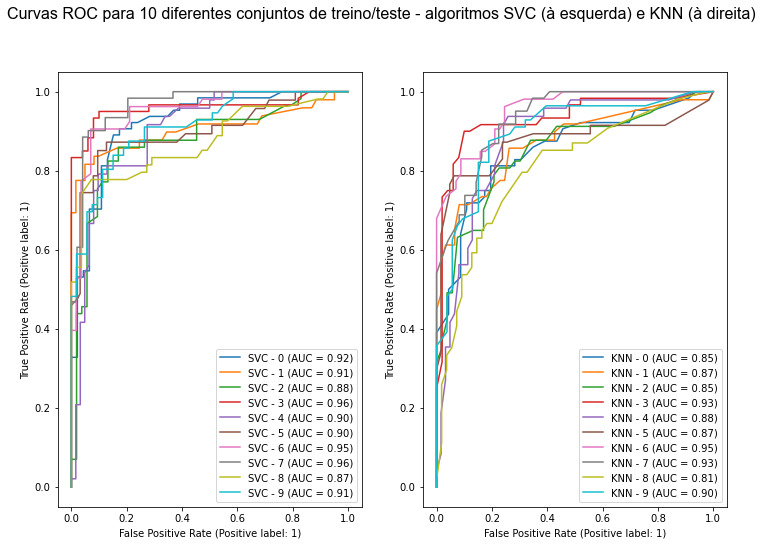

In [100]:
# Valores usados para identificar os subconjuntos de dados gerados pela validação cruzada (classe KFold)
i = 0
j = 0

# Listas para armazenar os subconjuntos de treinamento e teste gerados pela classe KFold
Xy_svm_1 = [None, None, None, None]
Xy_svm_2 = [None, None, None, None]

Xy_knn_1 = [None, None, None, None]
Xy_knn_2 = [None, None, None, None]

fig, axes = plt.subplots(1,2, figsize=(12,8)) # Configura uma figura com subplots

# Configura um título para a figura
fig.suptitle('Curvas ROC para 10 diferentes conjuntos de treino/teste - algoritmos SVC (à esquerda) e KNN (à direita)', 
             fontdict = {'family':'Arial','color':'black'}, fontsize = 16, ha = 'center', va = 'center')

kf = KFold(n_splits=10, shuffle=True, random_state=200) # Configura o algoritmo KFold

# Seleciona cada grupo de dados (k-fold) -> 10, ao todo
for treino_i, teste_i in kf.split(X):
    X_treino, X_teste = X.iloc[treino_i, :], X.iloc[teste_i, :] # Dados X_treino e X_teste obtidos por meio do K-fold
    y_treino, y_teste = y[treino_i], y[teste_i] # Dados y_treino e y_teste obtidos por meio do K-fold
    
    svmm = svm.SVC(C=svmp['C'], gamma=svmp['gamma'], kernel=svmp['kernel'], # Config e instancia o algoritmo SVC
                   probability=True, max_iter=1000000, random_state=200).fit(X_treino, y_treino)
    
    # Condições para salvar os subconjuntos de treino e teste gerados pelo KFold que resultaram em melhores curvas ROC
        
    if i == 3:
        
        Xy_svm_1[0] = X_treino
        Xy_svm_1[1] = X_teste
        Xy_svm_1[2] = y_treino
        Xy_svm_1[3] = y_teste
        
    elif j == 6:
        
        Xy_knn_1[0] = X_treino
        Xy_knn_1[1] = X_teste
        Xy_knn_1[2] = y_treino
        Xy_knn_1[3] = y_teste
        
    elif i == 8 and j == 8:
        
        Xy_svm_2[0] = Xy_knn_2[0] = X_treino
        Xy_svm_2[1] = Xy_knn_2[1] = X_teste
        Xy_svm_2[2] = Xy_knn_2[2] = y_treino
        Xy_svm_2[3] = Xy_knn_2[3] = y_teste
        
    
        
    
    # Plota as 10 curvas ROC para o SVC
    RocCurveDisplay.from_estimator(svmm, X_teste, y_teste, ax=axes[0], name = f'SVC - {i}')
    i += 1
    
    # Config e instancia o algoritmo KNN
    kmm = KNeighborsClassifier(algorithm='brute', metric=kmp['metric'], n_neighbors=kmp['n_neighbors']).fit(X_treino, y_treino)    
    
    # Plota as 10 curvas ROC para o KNN 
    RocCurveDisplay.from_estimator(kmm, X_teste, y_teste, ax=axes[1], name = f'KNN - {j}')    
    j += 1

**Os mesmos subconjuntos (ou grupos de dados) de teste e treinamento foram aplicados a cada algoritmo na mesma ordem, sendo possível perceber a diferença de adaptação entre eles.** 
<br><br>
**Os melhores desempenhos foram obtidos pelo 3° e 7° subconjunto para o algoritmo SVC (AUC = 0,96) e pelo 6° subconjunto para o KNN (AUC = 0,95).**
<br><br>
**Os piores desempenhos foram obtidos pelo 8° subconjunto para o algoritmo SVC (AUC = 0,87) e também pelo 8° subconjunto para o KNN (AUC = 0,81).**
<br><br>
**A curva ROC <font color='red'>vermelha</font> do algoritmo SVC possui AUC de 0.96, mas com um desempenho melhor de classificação para valores de sensibilidade de até aproximadamente 80%. Já a curva ROC <font color='red'>vermelha</font> para o algoritmo KNN possui AUC de 0.94, mas que desempenha melhor em valores de sensibilidade de até próximo de 60%.**
<br><br>
**Pode-se verificar que, pelas 2 melhores curvas ROC (uma para o SVC e outra para o KNN), a melhor performance é do algoritmo SVC.**

### 3.2 - Teste de acurácia para as <font color='red'>melhores</font> parametrizações e para o conjunto de dados de treino e teste que gera <font color='red'>maior</font> valor de AUC

In [101]:
# Config e instancia o algoritmo SVC
s = svm.SVC(C=svmp['C'], gamma=svmp['gamma'], kernel=svmp['kernel'], probability=True, 
               max_iter=10000000, random_state=200).fit(Xy_svm_1[0], Xy_svm_1[2])

In [102]:
# Faz as previsões com os dados X_teste, usando o SVC treinado
prevsS = s.predict(Xy_svm_1[1])

In [103]:
# Config e instancia o algoritmo KNN
k = KNeighborsClassifier(algorithm='brute', metric=kmp['metric'], n_neighbors=kmp['n_neighbors']).fit(Xy_knn_1[0], Xy_knn_1[2])

In [104]:
# Faz as previsões com os dados X_teste, usando o KNN treinado
prevsK = k.predict(Xy_knn_1[1])

In [105]:
# Exibe o accuracy score para o KNN
display(accuracy_score(Xy_knn_1[3], prevsK))

0.8454545454545455

In [106]:
# Tabela da Matriz de Confusão - KNN
pd.crosstab(Xy_knn_1[3], prevsK, rownames=['Real'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Real,,,
0,48,9,57
1,8,45,53
All,56,54,110


In [107]:
# Exibe o accuracy score para o SVC
display(accuracy_score(Xy_svm_1[3], prevsS))

0.9181818181818182

In [108]:
# Tabela da Matriz de Confusão - SVC
pd.crosstab(Xy_svm_1[3], prevsS, rownames=['Real'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Real,,,
0,46,4,50
1,5,55,60
All,51,59,110


**Os resultados mostram que o <font color='red'>SVC</font> demonstrou ser um classificador <font color='red'>melhor</font> para o conjunto Titanic, apresentando uma acurácia de <font color='green'>91.82%</font> contra <font color='green'>84.54%</font> do <font color='red'>KNN</font>**

### 3.3 - Teste de acurácia para as <font color='red'>melhores</font> parametrizações e para o conjunto de dados de treino e teste que gera <font color='green'>menor</font> valor de AUC

In [109]:
# Config e instancia o algoritmo SVC
s = svm.SVC(C=svmp['C'], gamma=svmp['gamma'], kernel=svmp['kernel'], probability=True, 
               max_iter=10000000, random_state=200).fit(Xy_svm_2[0], Xy_svm_2[2])

In [110]:
# Faz as previsões com os dados X_teste, usando o SVC treinado
prevsS = s.predict(Xy_svm_2[1])

In [111]:
# Config e instancia o algoritmo KNN
k = KNeighborsClassifier(algorithm='brute', metric=kmp['metric'], n_neighbors=kmp['n_neighbors']).fit(Xy_knn_2[0], Xy_knn_2[2])

In [112]:
# Faz as previsões com os dados X_teste, usando o KNN treinado
prevsK = k.predict(Xy_knn_2[1])

In [113]:
# Exibe o accuracy score para o KNN
display(accuracy_score(Xy_knn_2[3], prevsK))

0.7431192660550459

In [114]:
# Tabela da Matriz de Confusão - KNN
pd.crosstab(Xy_knn_2[3], prevsK, rownames=['Real'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Real,,,
0,45,10,55
1,18,36,54
All,63,46,109


In [115]:
# Exibe o accuracy score para o SVC
display(accuracy_score(Xy_svm_2[3], prevsS))

0.8073394495412844

In [116]:
# Tabela da Matriz de Confusão - SVC
pd.crosstab(Xy_svm_2[3], prevsS, rownames=['Real'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Real,,,
0,46,9,55
1,12,42,54
All,58,51,109


**Os resultados mostram que o <font color='red'>SVC</font> também apresentou um melhor valor de acurácia para esse caso, sendo <font color='green'>80.73%</font> contra <font color='green'>74.31%</font> do <font color='red'>KNN</font>**

**Pode-se concluir que os valores de acurácia, da área AUC e a forma da curva ROC variam com os subconjuntos de dados gerados pela classe KFold. Isso leva ao entendimento de que a aleatoriedade na seleção dos dados influencia nas respostas dos modelos, tanto na fase de treinamento quanto na fase de testes.**